Logistic growth models comparison - stochastic vs deterministic

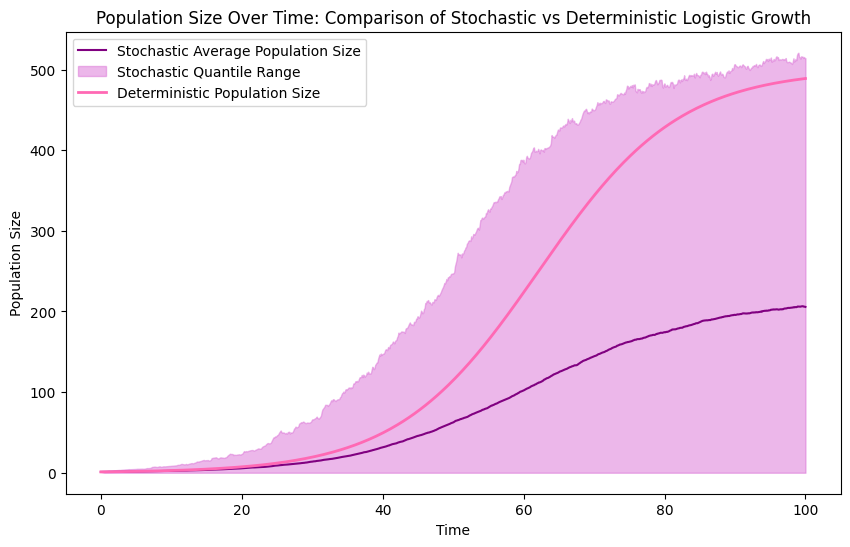

Extinction Probability: 0.57


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def set_parameters(initial_population=50, birth_rate=0.1, death_rate=0.1, competition_coefficient=0.01, carrying_capacity=500, max_time=100):
    return {
        'initial_population': initial_population,
        'birth_rate': birth_rate,
        'death_rate': death_rate,
        'carrying_capacity': carrying_capacity,
        'max_time': max_time
    }

def run_simulation(params):
    population = params['initial_population']
    birth_rate = params['birth_rate']
    death_rate = params['death_rate']
    max_time = params['max_time']
    carrying_capacity = params['carrying_capacity']
    
    time_points = [0]
    population_sizes = [population]
    
    while population > 0 and time_points[-1] < max_time:
        effective_birth_rate = params['birth_rate'] * (1 - population / carrying_capacity) + params['death_rate']*(population/carrying_capacity)
        next_event_time = np.random.exponential(1 / (death_rate*population + effective_birth_rate*population))
        
        if np.random.rand() < effective_birth_rate / (effective_birth_rate + death_rate):
            population += 1
        else:
            population -= 1
        
        time_points.append(time_points[-1] + next_event_time)
        population_sizes.append(population)
    
    return time_points, population_sizes

def run_multiple_simulations_with_quantiles(params, num_simulations=100):
    all_time_points = []
    all_population_sizes = []
    extinction_count = 0
    max_time = params['max_time']
    
    for _ in range(num_simulations):
        time_points, population_sizes = run_simulation(params)
        all_time_points.append(time_points)
        all_population_sizes.append(population_sizes)
        if population_sizes[-1] == 0:
            extinction_count += 1
    
    max_len = max(len(sim) for sim in all_population_sizes)
    num_points = 1000
    average_time_points = np.linspace(0, max_time, num_points)
    interpolated_populations = np.zeros((num_simulations, num_points))
    for i in range(num_simulations):
        interpolated_populations[i] = np.interp(average_time_points, all_time_points[i], all_population_sizes[i])
    average_population_sizes = np.mean(interpolated_populations, axis=0)
    lower_quantile = np.nanquantile(interpolated_populations, 0.05, axis=0)
    upper_quantile = np.nanquantile(interpolated_populations, 0.95, axis=0)
    
    extinction_probability = extinction_count / num_simulations
    
    return average_time_points, average_population_sizes, lower_quantile, upper_quantile, extinction_probability

def deterministic_logistic_growth(P0, r, K, t):
    return K / (1 + ((K - P0) / P0) * np.exp(-r * t))

def run_multiple_deterministic_simulations(P0, r, K, t_points, num_simulations=100):
    all_population_sizes = []
    
    for _ in range(num_simulations):
        P_t = deterministic_logistic_growth(P0, r, K, t_points)
        all_population_sizes.append(P_t)
    
    return all_population_sizes

def plot_combined_models(average_time_points, average_population_sizes_stochastic, lower_quantile, upper_quantile, average_population_sizes_deterministic, t_points):
    plt.figure(figsize=(10, 6))

    plt.plot(average_time_points, average_population_sizes_stochastic, color='purple', linestyle='-', label='Stochastic Average Population Size')
    plt.fill_between(average_time_points, lower_quantile, upper_quantile, color='orchid', alpha=0.5, label='Stochastic Quantile Range')
    
    plt.plot(t_points, average_population_sizes_deterministic, color='hotpink', linestyle='-', linewidth=2, label='Deterministic Population Size')

    plt.xlabel('Time')
    plt.ylabel('Population Size')
    plt.title('Population Size Over Time: Comparison of Stochastic vs Deterministic Logistic Growth')
    plt.legend()
    plt.show()

# Parameters for stochastic model
params = set_parameters(initial_population=1, birth_rate=0.2, death_rate=0.1)

# Multiple stochastic simulations
num_simulations = 100
average_time_points, average_population_sizes_stochastic, lower_quantile, upper_quantile, extinction_probability = run_multiple_simulations_with_quantiles(params, num_simulations)

# Parameters for deterministic model
P0 = 1  # Initial population size
r = 0.1  # Growth rate
K = 500  # Carrying capacity
t_max = 100  # Maximum time
t_points = np.linspace(0, t_max, 500)  # Time points

# Multiple deterministic simulations
average_population_sizes_deterministic = np.mean(run_multiple_deterministic_simulations(P0, r, K, t_points, num_simulations), axis=0)

# Plot combined results
plot_combined_models(average_time_points, average_population_sizes_stochastic, lower_quantile, upper_quantile, average_population_sizes_deterministic, t_points)

# Print extinction probability
print(f"Extinction Probability: {extinction_probability:.2f}")
